In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/Internal Project Sp25')

Mounted at /content/drive


Imports

In [73]:
# Standard imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# PyTorch imports
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

Load data, index by date

In [74]:
df = pd.read_csv('berkeley_decade_weather_data_daily.csv', parse_dates=["date"], index_col="date")

Sinusoidal encoding (optional feature engineering step)

In [75]:
def sinusoidal_encode(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index, dayfirst=True)

    day_of_year = df.index.dayofyear
    is_leap_year = df.index.is_leap_year
    days_in_year = np.where(is_leap_year, 366, 365)
    normalized_day = day_of_year / days_in_year

    df['sin_day'] = np.sin(2 * np.pi * normalized_day)
    df['cos_day'] = np.cos(2 * np.pi * normalized_day)

    return df

In [76]:
encoded_df = sinusoidal_encode(df)

Define target columns and exogenous columns, combine into one vector of all input columns

In [77]:
target_cols = ['temperature_max', 'temperature_min']
exog_cols = ['cloud_cover_afternoon', 'precipitation_total', 'temperature_morning', 'temperature_afternoon', 'temperature_night', 'temperature_evening', 'humidity_afternoon', 'sin_day', 'cos_day']

input_cols = target_cols + exog_cols

Z-score normalization of data

In [78]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(encoded_df[input_cols]), columns=input_cols, index=df.index)

Define hyperparameters. This step will look different when tuning.

In [79]:
'''
You should play around with these a lot. I will show you a more effective way to finetune them later.
'''

# main hyperparameters
input_seq_len = 21  # how many past time steps of all features you're using as input for each sequence
batch_size = 256  # how many sequences you look at before updating weights WITHIN an epoch; smaller size typically makes for more generalizable model, larger size typically makes for more complex model. Should be a power of 2 for GPU efficiency. Larger sizes are typically faster due to GPU's ability to process data within a batch in parallel.
hidden_size = 64  # number of hidden units in the LSTM cell; controls the "memory capacity" of the model
num_layers = 1  # how many LSTMs you have stacked on top of each other
num_epochs = 100  # number of full passes through the training data during optimization; each full batch will consist of many batches
lr = 0.0005 # learning rate: the initial step size used by the optimizer when updating weights

# optional hyperparameters
dropout_rate = 0.3  # fraction of values randomly set to zero in the LSTM’s output before the final linear layer; helps prevent overfitting
patience = 5  # number of consecutive epochs without validation improvement before stopping training early (early stopping)
l2 = 0  # strength of L2 regularization (a penalty term that discourages large weight values; helps prevent overfitting)

# hyperparameters that depend on your data; definitely don't play around with these lol
input_size = len(input_cols)
output_size = len(target_cols)

Convert tabular data to tensors so PyTorch can work with it

In [80]:
def create_tensors(data, target_cols, input_seq_len):
    '''
    PyTorch can't work with Pandas dataframes or standard lists; you need to first convert your data to numpy arrays and then convert those to tensors.
    '''
    sequences = []  # list of all sequenced data, including both target data and exogenous data. You can think of this as all data that will be used to make predictions (X)
    targets = []  # list of all corresponding targets. You can think of this as all data that you'd like to predict (y)

    for i in range(len(data) - input_seq_len): # iterate through all sequences within provided data. Will get sequence of shape (input_seq_len, num_features)
        seq = data.iloc[i:i+input_seq_len].values.astype(np.float32)  # look at individual sequence starting at index i and ending at index i+input_seq_len. Contains data of all features
        target = data.iloc[i+input_seq_len][target_cols].values.astype(np.float32)  # grab the target(s) for the time step immediately following the input sequence
        sequences.append(seq) # add this new sequence to list of sequences
        targets.append(target) # add new target to list of targets

    return torch.tensor(np.array(sequences)), torch.tensor(np.array(targets)).to(device) # convert to np arrays so that you can convert to PyTorch tensors

Create DataLoader so that PyTorch can use your data within a neural network.

In [81]:
def create_DataLoader(X, y, batch_size):
  '''
  Allows for batching and shuffling of data.
  '''
  dataset = TensorDataset(X, y) # Combines input and target tensors into a single dataset object; each sample becomes an (X, y) pair
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # Loads data into mini-batches of size batch_size, shuffles the data at the start of each epoch (shuffling is ok because data is already represented in sequence-target pairs)
  return dataloader

Define custom PyTorch neural network class to design our LSTM model architecture.

In [82]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        '''
        Defines the layers and structure of the LSTM model. Takes in model hyperparameters and uses them to build the core LSTM, regularization, and final output layers.
        '''
        super(LSTM, self).__init__()  # initializes the parent nn.Module class so we can use its built-in functionality
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate) # creates core LSTM layer that will process our input sequence
        self.dropout = nn.Dropout(dropout_rate)  # neural network version of regularization. Before converting final output to output_size, will randomly bring subset of values within final output to 0. Each value has a probability = dropout_rate of being brought to 0. This helps prevent overfitting
        self.fc = nn.Linear(hidden_size, output_size) # maps the final hidden state to the desired output dimensions (number of features you're predicting)

    def forward(self, x):
        '''
        Defines the forward pass logic: how input data flows through the network to produce an output.
        '''
        lstm_out, _ = self.lstm(x)  # passes the input sequence through the LSTM layer, producing an output for each time step in the sequence
        last_hidden = lstm_out[:, -1, :]  # only use the last output in the sequence
        dropped = self.dropout(last_hidden) # apply dropout to the output of the last layer
        return self.fc(dropped) # feed the final hidden state into the fully connected layer to produce the final prediction in the correct dimensionality

Create model

In [83]:
model = LSTM(input_size, hidden_size, output_size, num_layers, dropout_rate)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1



Load train/val data

In [84]:
train = df_scaled.loc[df_scaled.index < '2023-01-01']
val = df_scaled.loc[df_scaled.index >= '2023-01-01']

X, y = create_tensors(df_scaled, target_cols, input_seq_len)

train_X, train_y = create_tensors(train, target_cols, input_seq_len)
val_X, val_y = create_tensors(val, target_cols, input_seq_len)

Make DataLoaders

In [85]:
train_loader = create_DataLoader(train_X, train_y, batch_size)
val_loader = create_DataLoader(val_X, val_y, batch_size)

Define loss function and optimizer

In [86]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [90]:
# Initialize the best validation loss to infinity so any actual loss will be lower
best_val_loss = float('inf')

# Counter to track how many epochs have passed without improvement
patience_counter = 0

# Iterate through each epoch of training. This loop is basically the equivalent of ".fit()" as you've probably used in sklearn and such
device = next(model.parameters()).device
for epoch in range(num_epochs):
    model.train()  # Set model to training mode (activates dropout, batch norm, etc.)
    train_losses = []  # List to store training loss for this epoch

    # Iterate over each batch in the training DataLoader
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)  # Forward pass: predict using the model
        loss = criterion(pred, yb)  # Compute loss between predictions and true labels
        optimizer.zero_grad()  # Clear previous gradients to prevent accumulation
        loss.backward()  # Backpropagate to compute gradients
        optimizer.step()  # Update model weights based on gradients
        train_losses.append(loss.item())  # Store the loss for this batch

    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    val_losses = []  # List to store validation loss

    with torch.no_grad():  # Disable gradient computation for validation. Without this line, model stays the same, but is slower + more memory is used calculating the gradients in the background
    # Iterate over each batch in the validation DataLoader
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)  # Forward pass on validation batch
            loss = criterion(pred, yb)  # Compute validation loss
            val_losses.append(loss.item())  # Store the loss

    # Compute average validation loss for the epoch
    avg_val_loss = np.mean(val_losses)

    # Print training and validation metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {avg_val_loss:.4f}")

    # --- Early stopping check ---
    if avg_val_loss < best_val_loss:
        # If validation loss improved, update the best value and reset the counter
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Save the current best model
    else:
        # If validation loss didn't improve, increment the patience counter
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s)")

        # If validation hasn't improved for 'patience' epochs, stop training early
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break  # Exit the training loop


Epoch 1/100, Train Loss: 1.0367, Val Loss: 0.9244
Epoch 2/100, Train Loss: 0.8433, Val Loss: 0.7314
Epoch 3/100, Train Loss: 0.6592, Val Loss: 0.5127
Epoch 4/100, Train Loss: 0.4753, Val Loss: 0.3519
Epoch 5/100, Train Loss: 0.3980, Val Loss: 0.3336
Epoch 6/100, Train Loss: 0.3678, Val Loss: 0.3112
Epoch 7/100, Train Loss: 0.3510, Val Loss: 0.3089
Epoch 8/100, Train Loss: 0.3393, Val Loss: 0.2958
Epoch 9/100, Train Loss: 0.3228, Val Loss: 0.2943
Epoch 10/100, Train Loss: 0.3152, Val Loss: 0.2852
Epoch 11/100, Train Loss: 0.3069, Val Loss: 0.2851
Epoch 12/100, Train Loss: 0.3015, Val Loss: 0.2798
Epoch 13/100, Train Loss: 0.2976, Val Loss: 0.2713
Epoch 14/100, Train Loss: 0.2909, Val Loss: 0.2681
Epoch 15/100, Train Loss: 0.2763, Val Loss: 0.2649
Epoch 16/100, Train Loss: 0.2763, Val Loss: 0.2581
Epoch 17/100, Train Loss: 0.2699, Val Loss: 0.2533
Epoch 18/100, Train Loss: 0.2629, Val Loss: 0.2455
Epoch 19/100, Train Loss: 0.2599, Val Loss: 0.2421
Epoch 20/100, Train Loss: 0.2613, Val Lo

Overall evaluation

In [94]:
def get_predictions(model, X):
    '''
    Create a function that changes the model to evaluation mode and use this to return predictions.
    '''
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm, etc.)
    preds = []  # Initialize list to store prediction batches

    with torch.no_grad():  # Disable gradient tracking for inference
        for i in range(0, len(X), 64):  # Iterate through X in batches of size 64
            xb = X[i:i+64]  # Slice the current batch of inputs
            pred = model(xb)  # Run forward pass on the batch
            preds.append(pred.detach().cpu().numpy())  # Convert prediction tensor to NumPy and store it

    return np.concatenate(preds, axis=0)  # Combine all prediction batches into one array

def inverse_scale_targets(scaler, data, target_cols, exog_cols):
    '''
    Create a function that reverses normalization steps we did earlier
    '''
    zeros = np.zeros((data.shape[0], len(exog_cols)))  # Create dummy zeros for exogenous columns
    stacked = np.concatenate([data, zeros], axis=1)  # Stack targets + dummy exogenous features
    full_inverse = scaler.inverse_transform(stacked)  # Apply inverse scaling using the original scaler
    return full_inverse[:, :len(target_cols)]  # Return only the target columns (not the dummy zeros)

def evaluate_metrics(y_true, y_pred, target_names):
    '''
    Create a function that calculates error metrics for each target variable
    '''
    metrics = []  # Store metrics for each target

    for i, col in enumerate(target_names):  # Loop through each target feature by index and name
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])  # Compute MSE for this target
        rmse = np.sqrt(mse)  # Compute RMSE from MSE
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])  # Compute MAE
        r2 = r2_score(y_true[:, i], y_pred[:, i])  # Compute R-squared
        metrics.append({'Target': col, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2})  # Store as a dict

    return pd.DataFrame(metrics)  # Return all metrics as a DataFrame

In [98]:
def evaluate_model_on_df(model, df_scaled, X, y, scaler, target_cols, exog_cols, sequence_length, split_date='2023-01-01'):
    '''
    Combine functions we just made into one function that will output comprehensive evaluation metrics for the model.
    '''
    target_dates = df_scaled.index[sequence_length:]  # Get the list of dates corresponding to each prediction (i.e., starting after the first full sequence)
    split_date = pd.to_datetime(split_date) # Convert split_date string to datetime format for comparison
    mask = target_dates >= split_date # Create a boolean mask where True means the date is in the validation set
    train_mask = ~mask  # Create the opposite mask — True for training dates

    if isinstance(y, torch.Tensor):
      y = y.detach().cpu().numpy()
    preds_all = get_predictions(model, X) # Run the model to get predictions on the entire dataset (X)
    preds_unscaled = inverse_scale_targets(scaler, preds_all, target_cols, exog_cols) # Inverse transform predicted values
    y_unscaled = inverse_scale_targets(scaler, y, target_cols, exog_cols) # Inverse transform actual values

    preds_train, preds_val = preds_unscaled[train_mask], preds_unscaled[mask] # Use the masks to split predicted values into train and validation sets
    y_train, y_val = y_unscaled[train_mask], y_unscaled[mask] # Use the masks to split actual values into train and validation sets

    train_metrics = evaluate_metrics(y_train, preds_train, target_cols) # Compute metrics (MSE, RMSE, MAE) for the training data
    val_metrics = evaluate_metrics(y_val, preds_val, target_cols) # Compute metrics for the validation data

    # Add a column to indicate which split each row belongs to
    train_metrics['Split'] = 'Train'
    val_metrics['Split'] = 'Validation'

    # Combine both metrics into a single DataFrame for easy comparison
    return pd.concat([train_metrics, val_metrics], ignore_index=True)

In [99]:
# Get predictions!
results = evaluate_model_on_df(
    model=model,
    df_scaled=df_scaled,
    X=X,
    y=y,
    scaler=scaler,
    target_cols=target_cols,
    exog_cols=exog_cols,
    sequence_length=input_seq_len
)

print(results)

            Target        MSE      RMSE       MAE        R²       Split
0  temperature_max  17.130394  4.138888  3.152584  0.798367       Train
1  temperature_min   5.288506  2.299675  1.766456  0.853124       Train
2  temperature_max  19.625468  4.430064  3.221751  0.793412  Validation
3  temperature_min   4.860415  2.204635  1.675490  0.850005  Validation


In [101]:
print(type(y))

<class 'torch.Tensor'>


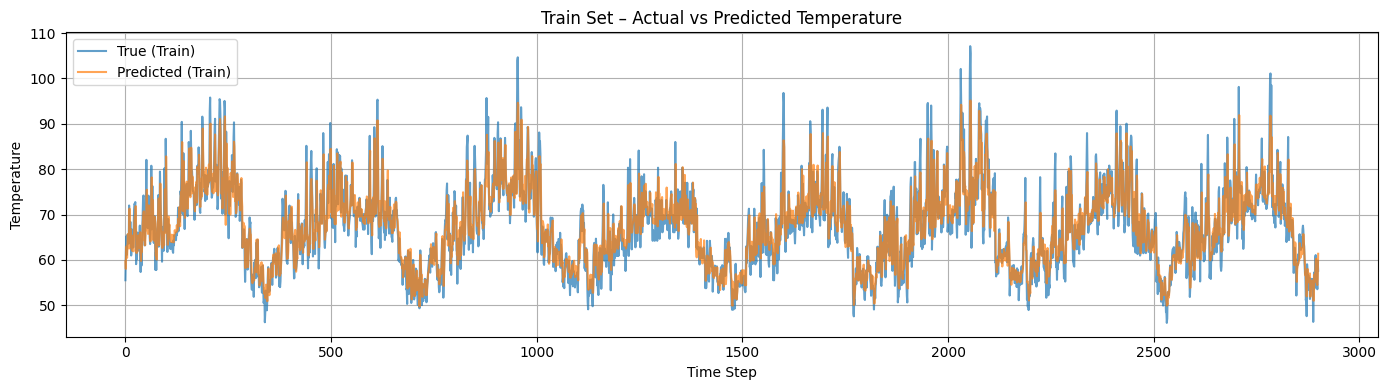

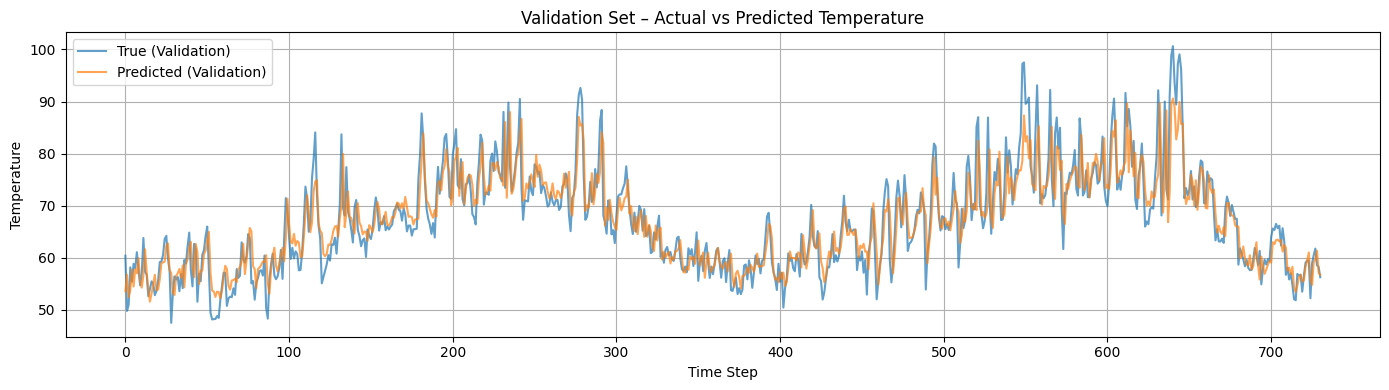

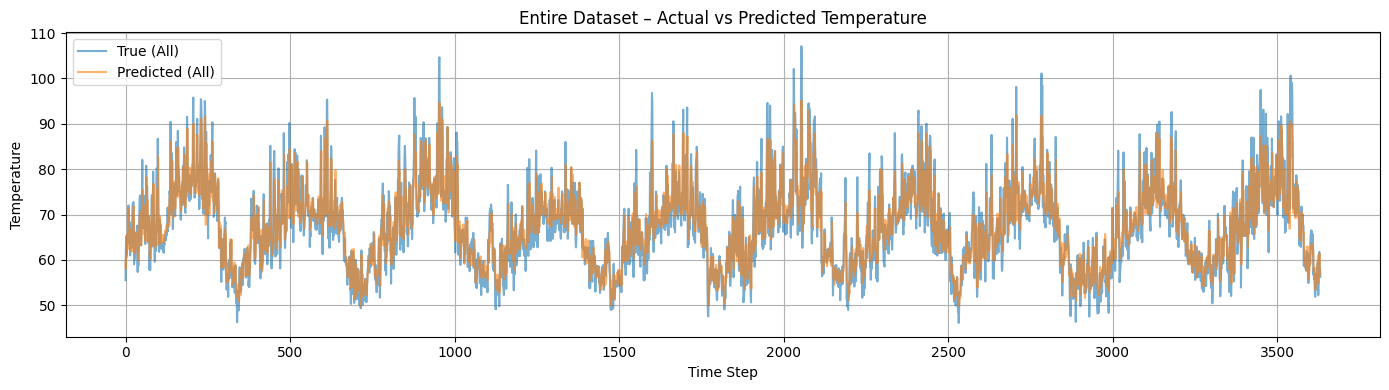

In [103]:
import matplotlib.pyplot as plt

# Get unnormalized predictions and targets
preds_all = get_predictions(model, X)
preds_unscaled = inverse_scale_targets(scaler, preds_all, target_cols, exog_cols)
if isinstance(y, torch.Tensor):
  y = y.detach().cpu().numpy()
y_unscaled = inverse_scale_targets(scaler, y, target_cols, exog_cols)

# Create masks for train/val split
target_dates = df_scaled.index[input_seq_len:]
split_date = pd.to_datetime('2023-01-01')  # Change this if needed
mask = target_dates >= split_date
train_mask = ~mask

# Separate predictions and targets by split
preds_train, preds_val = preds_unscaled[train_mask], preds_unscaled[mask]
y_train, y_val = y_unscaled[train_mask], y_unscaled[mask]

# Select temperature column index (assume first)
temp_idx = 0  # Update this if needed

# === Plot 1: Train ===
plt.figure(figsize=(14, 4))
plt.plot(y_train[:, temp_idx], label='True (Train)', alpha=0.7)
plt.plot(preds_train[:, temp_idx], label='Predicted (Train)', alpha=0.7)
plt.title("Train Set – Actual vs Predicted Temperature")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Validation ===
plt.figure(figsize=(14, 4))
plt.plot(y_val[:, temp_idx], label='True (Validation)', alpha=0.7)
plt.plot(preds_val[:, temp_idx], label='Predicted (Validation)', alpha=0.7)
plt.title("Validation Set – Actual vs Predicted Temperature")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: All ===
plt.figure(figsize=(14, 4))
plt.plot(y_unscaled[:, temp_idx], label='True (All)', alpha=0.6)
plt.plot(preds_unscaled[:, temp_idx], label='Predicted (All)', alpha=0.6)
plt.title("Entire Dataset – Actual vs Predicted Temperature")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [104]:
!pip install optuna

In [105]:
import optuna
from optuna.trial import TrialState

In [106]:
def objective(trial):
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 2)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    l2 = trial.suggest_float("l2", 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTM(input_size, hidden_size, output_size, num_layers, dropout=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    criterion = nn.MSELoss()

    train_loader = create_DataLoader(train_X, train_y, batch_size)
    val_loader = create_DataLoader(val_X, val_y, batch_size)

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_preds = model(X_val_batch)
                val_loss = criterion(val_preds, y_val_batch)
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss

In [107]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=12)
# study.optimize(objective, timeout=600)

print("Best trial:")
trial = study.best_trial
for key, value in trial.params.items():
    print(f"  {key}: {value}")

[I 2025-08-02 00:21:03,591] A new study created in memory with name: no-name-dff9daf4-d687-49f6-a2d2-4bbeb1a72ccb
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1

[I 2025-08-02 00:21:08,798] Trial 0 finished with value: 0.1893132949868838 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.4474137785682095, 'lr': 0.0006444676356914904, 'l2': 0.00019267946008439863, 'batch_size': 128}. Best is trial 0 with value: 0.1893132949868838.
[I 2025-08-02 00:21:23,011] Trial 1 finished with value: 0.1742925201745137 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout_rate': 0.1894255944916574, 'lr': 0.0006872937894242012, 'l2': 6.821547955912395e-06, 'batch_size': 32}. Best is trial 1 with value: 0.1742925201745137.
[I 2025-08-02 00:21:26,030] Trial 2 finished with value: 0.18815

Best trial:
  hidden_size: 128
  num_layers: 2
  dropout_rate: 0.49922502903328164
  lr: 0.001411225824105761
  l2: 7.349858885473247e-05
  batch_size: 64


In [108]:
optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_optimization_history(study)

In [110]:
best_params = study.best_params

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(
    input_size=input_size,
    hidden_size=best_params["hidden_size"],
    output_size=output_size,
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout_rate"]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["l2"])

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
train_loader = create_DataLoader(X, y, batch_size=best_params["batch_size"])

/tmp/ipython-input-3294725370.py:14: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [111]:
num_epochs = 100  # you can adjust this if needed

model.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

In [114]:
model.eval()
if isinstance(y, torch.Tensor):
  y = y.detach().cpu().numpy()
X = X.to(device)

with torch.no_grad():
    results = evaluate_model_on_df(
        model=model,
        df_scaled=df_scaled,
        X=X,
        y=y,
        scaler=scaler,
        target_cols=target_cols,
        exog_cols=exog_cols,
        sequence_length=input_seq_len
    )

print(results)

            Target       MSE      RMSE       MAE        R²       Split
0  temperature_max  7.992101  2.827030  2.200297  0.905929       Train
1  temperature_min  2.440350  1.562162  1.220032  0.932225       Train
2  temperature_max  8.831588  2.971799  2.224984  0.907034  Validation
3  temperature_min  2.376936  1.541732  1.185047  0.926646  Validation


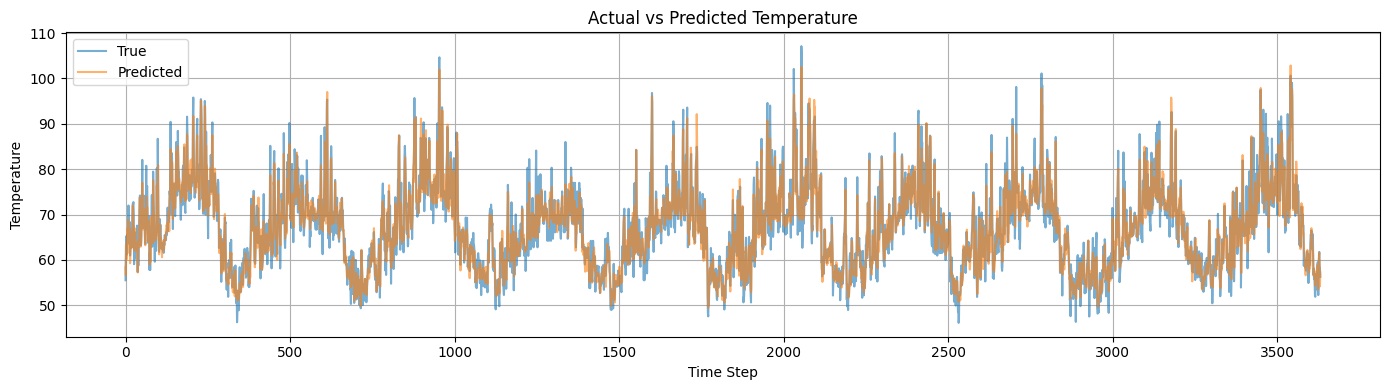

In [115]:
import matplotlib.pyplot as plt

preds_all = get_predictions(model, X)
preds_unscaled = inverse_scale_targets(scaler, preds_all, target_cols, exog_cols)
y_unscaled = inverse_scale_targets(scaler, y, target_cols, exog_cols)

temp_idx = 0

plt.figure(figsize=(14, 4))
plt.plot(y_unscaled[:, temp_idx], label='True', alpha=0.6)
plt.plot(preds_unscaled[:, temp_idx], label='Predicted', alpha=0.6)
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "params": best_params,
    "input_size": input_size,
    "output_size": output_size,
}, "best_lstm_checkpoint.pth")

In [ ]:
# If you want to load model in another notebook without retraining


"""
checkpoint = torch.load("best_lstm_checkpoint.pth", map_location=torch.device("cpu"))

model = LSTM(
    input_size=checkpoint["input_size"],
    hidden_size=checkpoint["params"]["hidden_size"],
    output_size=checkpoint["output_size"],
    num_layers=checkpoint["params"]["num_layers"],
    dropout=checkpoint["params"]["dropout_rate"]
)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
"""